Purpose - solve for the input spectra from the diffraction pattern through 1-D square aperture.
Perfect noiseless linear system

# Ideal noise-free reconstruction

Import

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


Establish data structures

In [143]:
#set spectral channels
numChannels = 1000
wvstart = 800e-9
wvend = 900e-9
wvvec = np.linspace(wvstart,wvend,numChannels)
wvres = (wvend-wvstart)/numChannels
print('Wavelength Resolution is {0} nm'.format(wvres*1e9))

#set simulation size and spatial resolution
z = 1 # propagation distance [m]
l = 1e-3 # feature size
Nf = np.power((l/2),2)/(wvstart*z)
print('Fresnel Number equals {0}'.format(Nf))
aliasLvl = 1e-4
M = 100 #how many points to sample the feature with
Q = 100 #scale factor between feature and surrounding
N = Q*M #total number of sampling points. 
deltax = l/M 
print('DeltaX is {0} mm with {1} points'.format(deltax*1e3,N))


Wavelength Resolution is 0.09999999999999999 nm
Fresnel Number equals 0.3125
DeltaX is 0.01 mm with 10000 points


Set up functions for forward model

Create PSF calibration matrix

In [144]:
def createHTransferFunc(deltax,N, z, lam):
    delfx = 1/(-deltax*N/2)
    fxvec = np.arange(-delfx*N/2,delfx*N/2,delfx)
    H = np.exp(1j*2.0*np.pi/lam*z)*np.exp(-1j* np.pi*lam*z*(np.power(fxvec,2)))
    H = np.array(H)
    return H

def createAperture(M,N):
    xvec = np.arange(-deltax*N/2,deltax*N/2,deltax)
    aperture = np.zeros((N))
    center = int(N/2)
    edge = int(M/2)
    aperture[center-edge:center+edge+1] = 1
    return aperture

def FresnelForward(lam, z, aperture, H):
    apertureFFT = np.fft.fft(aperture)
    apertureFFT2 = np.fft.fftshift(apertureFFT)
    yfft = apertureFFT2*H
    y = np.fft.fft(yfft)
    return y 


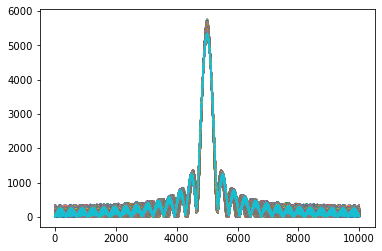

In [145]:
#Create single pattern of y. 

PSF = np.empty((N,numChannels))
plt.figure()

for k in np.arange(numChannels):
    lam = wvvec[k]
    aperture = createAperture(M,N)
    H = createHTransferFunc(deltax, N, z, lam)
    y = FresnelForward(lam, z, aperture, H)
    plt.plot(abs(y))
    PSF[:,k] = abs(y)
plt.show()


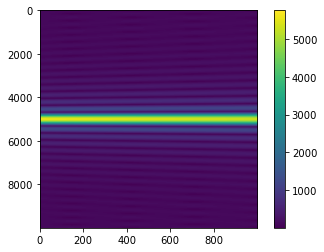

In [146]:
fig = plt.figure()
ax = fig.add_subplot(111)
pos = ax.imshow(np.asarray(PSF))
ax.set_aspect(numChannels/N)
fig.colorbar(pos, ax=ax)

Create simulated output image

Text(0, 0.5, 'Intensity')

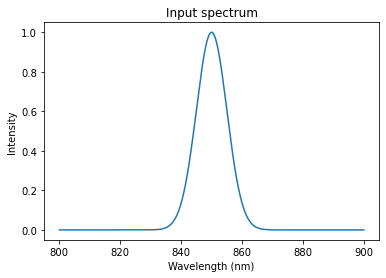

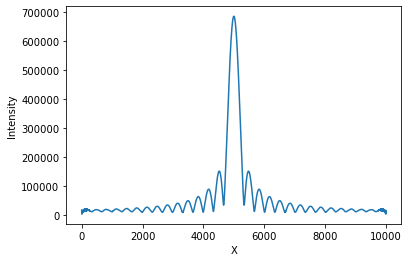

In [160]:
inputspectra = signal.gaussian(numChannels,std = 50)
plt.plot(wvvec*1e9,inputspectra)
plt.title('Input spectrum')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')

measurement = ForwardModel(inputspectra,PSF)
ytrue = measurement
plt.figure()
plt.plot(measurement)
plt.xlabel('X')
plt.ylabel('Intensity')

-608668906.0987945


Text(0.5, 0, 'X')

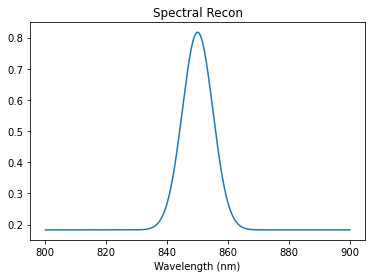

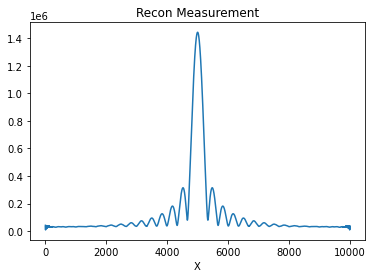

In [163]:
def ForwardModel(x,A): 
    y = A@x
    return y

def PseudoInverse(error, A):
    invA = np.linalg.inv(A.T@A)
    gradDir = invA@A.T
    xgrad = gradDir@error
    return xgrad.T

numIter = 100

initSpectra = np.ones(numChannels)

x = initSpectra*.5
stepSize = 1e-2
A = PSF

for iter in np.arange(numIter):
    ym = ForwardModel(x,A)
    error = ytrue-ym
    grads = PseudoInverse(error.T,A)
    x = np.add(x,stepSize*grads)
    #print(np.sum(error))
print(np.sum(error))
plt.plot(wvvec*1e9,x)
plt.title('Spectral Recon')
plt.xlabel('Wavelength (nm)')
plt.figure()
plt.plot(ym)
plt.title('Recon Measurement')
plt.xlabel('X')

## Noisy reconstruction

Add some noise to the measurement.

In [2]:
SNR = 100
mMean = np.sum(measurement)/N/SNR
noise = np.random.normal(0,mMean,N)

noisymeasurement = np.add(measurement,noise)
plt.plot(noisymeasurement)

ytrue = noisymeasurement

NameError: name 'np' is not defined

Solve for input spectrum using Gradient Descent

-1646185217.7540822
-1489458236.9942122
-1347652895.5596309
-1219348536.2088435
-1103259759.4259865
-998223545.8231833
-903187604.5913279
-817199831.2698445
-739398769.2195606
-669004979.2382599


<function matplotlib.pyplot.show(close=None, block=None)>

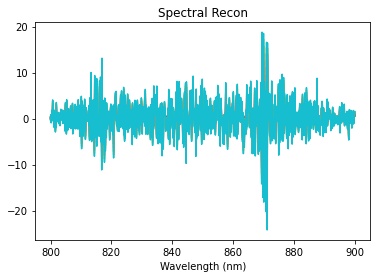

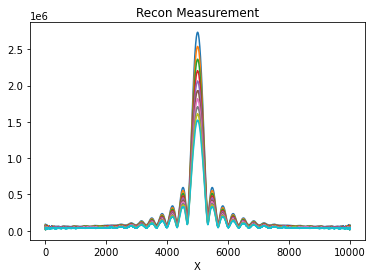

In [174]:
def ForwardModel(x,A): 
    y = A@x
    return y

def PseudoInverse(error, A):
    invA = np.linalg.inv(A.T@A)
    gradDir = invA@A.T
    xgrad = gradDir@error
    return xgrad.T

numIter = 1000
plotevery = 100

initSpectra = np.ones(numChannels)

x = initSpectra*.5
stepSize = 1e-3
A = PSF

for iter in np.arange(numIter):
    ym = ForwardModel(x,A)
    error = ytrue-ym
    grads = PseudoInverse(error.T,A)
    x = np.add(x,stepSize*grads)
    #print(np.sum(error))
    if iter%plotevery == 0:
        print(np.sum(error))
        plt.figure(1)
        plt.plot(wvvec*1e9,x)
        plt.title('Spectral Recon')
        plt.xlabel('Wavelength (nm)')
        plt.figure(2)
        plt.plot(ym)
        plt.title('Recon Measurement')
        plt.xlabel('X')
plt.show

Incorporate nonnegativity prior (and others).  Use sklearn toolkit

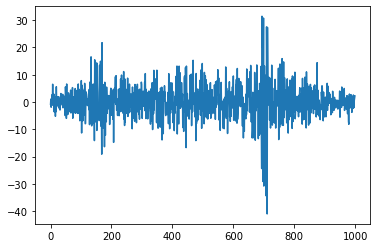

In [184]:
#ordinary least squares
from sklearn import linear_model as lm

reg = lm.LinearRegression()
reg.fit(A,ytrue)
x=reg.coef_

plt.plot(x)

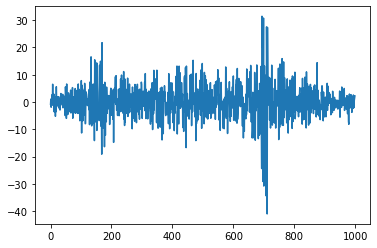

In [193]:
#ridge regression
reg2 = lm.Ridge(alpha = 0.5)
reg2.fit(A,ytrue)
x2 = reg2.coef_

plt.plot(x2)

/Users/neerja42/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147283530126.28513, tolerance: 12818674847.923231
  model = cd_fast.enet_coordinate_descent(


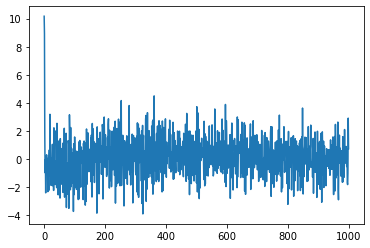

In [194]:
#lasso
reg3 = lm.Lasso(alpha=0.0001)
reg3.fit(A,ytrue)
x3=reg3.coef_
plt.plot(x3)